<a href="https://colab.research.google.com/github/farazabir/dragme-recommendation/blob/main/dragmerecomendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import numpy as np
import pandas as pd

In [14]:
apiurl = "https://prod.dragme.io/all-performances"
token = ""

In [26]:
response = requests.get(apiurl, headers={"Authorization": f"{token}"})
data = response.json()

In [27]:
df = pd.DataFrame(data['data'])
df.to_csv("eventdata.csv")

In [28]:
df.count()

,0
id,6386
uuid,3809
event_date,6371
event_name,6386
artist,0
location,6386
ticket_link,6386
venue_uuid,726
img_url,5344
event_info,6386


In [30]:
df.head()

,id,uuid,event_date,event_name,artist,location,ticket_link,venue_uuid,img_url,event_info,base_price,age_minimum,currency,ticket_fees,ticket_limit,tickets_on_sale,event_time,provider,user_id,is_approved
0,1052,None,2024-06-06T23:00:00.000Z,Science is a Drag,None,"739 Queen Street West #2nd Floor, Toronto, ON ...",https://www.eventbrite.ca/e/science-is-a-drag-...,None,None,Science like you've never seen her before,None,None,CAD,None,None,None,19:00:00,None,NaN,1
1,1053,None,2024-05-11T23:00:00.000Z,"Exposed with Georgie Girl, Sofonda Cox & guests.",None,"459 Church Street Second floor, Toronto, ON M4...",https://www.eventbrite.ca/e/exposed-with-georg...,None,None,One of the longest running Drag Shows in Toron...,None,None,CAD,None,None,None,19:00:00,None,NaN,1
2,1054,None,2024-05-11T17:30:00.000Z,Illusions The Drag Brunch Toronto - Drag Queen...,None,"575 King St W, Toronto, ON M5V 1M1, Canada, To...",https://www.eventbrite.com/e/illusions-the-dra...,None,None,Illusions Drag Brunch Toronto is the Ultimate ...,None,None,CAD,None,None,None,13:30:00,None,NaN,1
3,1055,None,2024-05-11T00:30:00.000Z,Crews and Tangos Drag Show,None,"508 Church Street, Toronto, ON M4Y 2C8, Canada...",https://www.eventbrite.ca/e/crews-and-tangos-d...,None,None,"Crews & Tangos, Toronto’s #1 Drag Bar, is loca...",None,None,CAD,None,None,None,20:30:00,None,NaN,1
4,1056,None,2024-05-11T00:00:00.000Z,The Dmanda Show!,None,"459 Church Street Second floor, Toronto, ON M4...",https://www.eventbrite.ca/e/the-dmanda-show-ti...,None,None,Friday Night Drag Race viewing party and live ...,None,None,CAD,None,None,None,20:00:00,None,NaN,1


In [32]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp311-cp311-linux_x86_64.whl size=553318 sha256=15ba07d8e4f4438fb3c5be26e39ea83ac422cae4b272002a03ffaf7e6580ec53
  Stored in directory: /root/.cache/pip/wheels/33/e5/58/0a3e34b92bedf09b4c57e37a63ff395ade6f6c1099ba59877c
Successfully built annoy


In [105]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from annoy import AnnoyIndex
import matplotlib.pyplot as plt

In [106]:
df = pd.read_csv("eventdata.csv")

In [107]:
def preprocess_text(row):

    location = row.get("location", "") if isinstance(row.get("location", ""), str) else ""
    city_match = re.findall(r"([A-Za-z]+), [A-Z]{2}", location)
    city = city_match[0] if city_match else ""

    text_features = [
        row.get("event_name", "") if isinstance(row.get("event_name", ""), str) else "",
        city,
        row.get("event_info", "") if isinstance(row.get("event_info", ""), str) else "",
    ]

    return ' '.join(filter(None, text_features)).lower()

df['location'] = df['location'].fillna('')
df['event_name'] = df['event_name'].fillna('')
df['event_info'] = df['event_info'].fillna('')


In [108]:
df['location'] = df['location'].fillna('')
df['event_name'] = df['event_name'].fillna('')
df['event_info'] = df['event_info'].fillna('')

In [109]:
df['combined_text'] = df.apply(preprocess_text, axis=1)

In [110]:
df.head()

,Unnamed: 0,id,uuid,event_date,event_name,artist,location,ticket_link,venue_uuid,img_url,...,age_minimum,currency,ticket_fees,ticket_limit,tickets_on_sale,event_time,provider,user_id,is_approved,combined_text
0,0,1052,NaN,2024-06-06T23:00:00.000Z,Science is a Drag,NaN,"739 Queen Street West #2nd Floor, Toronto, ON ...",https://www.eventbrite.ca/e/science-is-a-drag-...,NaN,NaN,...,NaN,CAD,NaN,NaN,NaN,19:00:00,NaN,NaN,1,science is a drag toronto science like you've ...
1,1,1053,NaN,2024-05-11T23:00:00.000Z,"Exposed with Georgie Girl, Sofonda Cox & guests.",NaN,"459 Church Street Second floor, Toronto, ON M4...",https://www.eventbrite.ca/e/exposed-with-georg...,NaN,NaN,...,NaN,CAD,NaN,NaN,NaN,19:00:00,NaN,NaN,1,"exposed with georgie girl, sofonda cox & guest..."
2,2,1054,NaN,2024-05-11T17:30:00.000Z,Illusions The Drag Brunch Toronto - Drag Queen...,NaN,"575 King St W, Toronto, ON M5V 1M1, Canada, To...",https://www.eventbrite.com/e/illusions-the-dra...,NaN,NaN,...,NaN,CAD,NaN,NaN,NaN,13:30:00,NaN,NaN,1,illusions the drag brunch toronto - drag queen...
3,3,1055,NaN,2024-05-11T00:30:00.000Z,Crews and Tangos Drag Show,NaN,"508 Church Street, Toronto, ON M4Y 2C8, Canada...",https://www.eventbrite.ca/e/crews-and-tangos-d...,NaN,NaN,...,NaN,CAD,NaN,NaN,NaN,20:30:00,NaN,NaN,1,crews and tangos drag show toronto crews & tan...
4,4,1056,NaN,2024-05-11T00:00:00.000Z,The Dmanda Show!,NaN,"459 Church Street Second floor, Toronto, ON M4...",https://www.eventbrite.ca/e/the-dmanda-show-ti...,NaN,NaN,...,NaN,CAD,NaN,NaN,NaN,20:00:00,NaN,NaN,1,the dmanda show! toronto friday night drag rac...


In [111]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['combined_text'])

In [112]:
dimensions = tfidf_matrix.shape[1]
ann_index = AnnoyIndex(dimensions, 'angular')

In [113]:
for i in range(tfidf_matrix.shape[0]):
    ann_index.add_item(i, tfidf_matrix[i].toarray()[0])

ann_index.build(10)
ann_index.save('event_index.ann')

True

In [114]:
def get_recommendations(event_id, top_n=5):
    """
    get top N similar events for a given eventid as dictionaries.
    """
    try:
        idx = df[df['id'] == event_id].index[0]
        similar_items = ann_index.get_nns_by_item(idx, top_n + 1)[1:]
        return df.iloc[similar_items].to_dict('records')
    except IndexError:
        return {"error": "Event ID not found in the dataset."}

In [115]:
event_id = 13052
recommendations = get_recommendations(event_id, top_n=5)

In [116]:
for rec in recommendations:
    print(rec)

{'Unnamed: 0': 6273, 'id': 13045, 'uuid': 'f55244e9-c6af-49ba-a5f0-07d520cc8dcf', 'event_date': '2024-11-10T00:00:00.000Z', 'event_name': 'Drag Brunch at Glad Day in Toronto', 'artist': nan, 'location': 'location          Toronto, ON\nlocation    499 Church Street\nName: 230, dtype: object', 'ticket_link': nan, 'venue_uuid': nan, 'img_url': 'https://img.evbuc.com/https%3A%2F%2Fcdn.evbuc.com%2Fimages%2F474753459%2F192434174493%2F1%2Foriginal.20230322-023202?auto=format%2Ccompress&q=75&sharp=10&s=389998a4755444f3fd4c4000527a2e08', 'event_info': "It's Canada's longest running DRAG BRUNCH with your favourite host Selena Vyle!\nThere are two seatings: 11am and 2pm.\n\nThe 11am seating ends at 1pm so we have time to reset and sanitize the space for the 2pm seating.\n\nFor the 11am seating, the show starts at 11:30am.\n\nFor the 2pm seating, the show starts at 2:20pm.\n\nEvery week we serve you more than you can handle and you eat it up! A different guest each week, delicious brunch and a vib

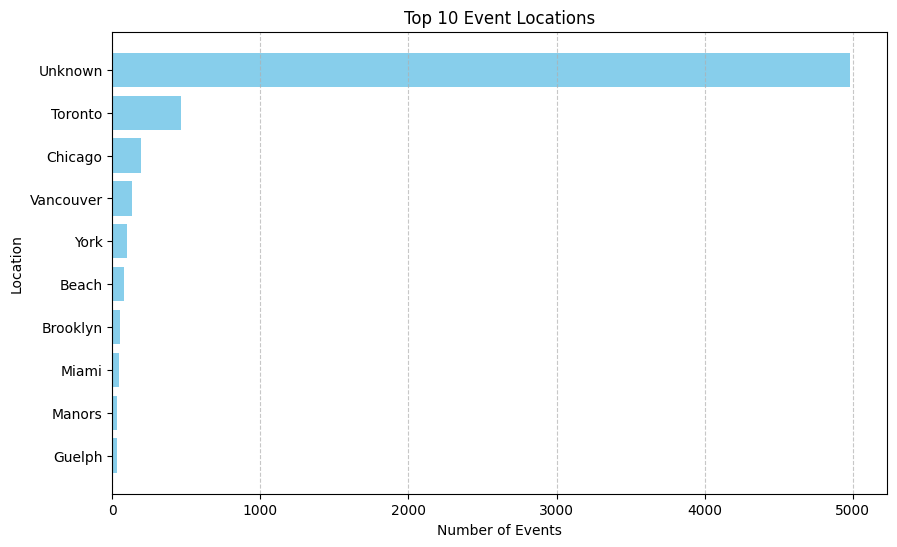

In [119]:
def plot_event_locations():

    df['city'] = df['location'].apply(
        lambda x: re.findall(r"([A-Za-z]+), [A-Z]{2}", x)[0] if pd.notnull(x) and re.search(r"[A-Za-z]+, [A-Z]{2}", x) else "Unknown"
    )
    location_counts = df['city'].value_counts().head(10)

    plt.figure(figsize=(10, 6))
    plt.barh(location_counts.index, location_counts.values, color='skyblue')
    plt.title('Top 10 Event Locations')
    plt.xlabel('Number of Events')
    plt.ylabel('Location')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

plot_event_locations()
